In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn import metrics

import re, seaborn as sns, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
from mpl_toolkits.mplot3d import Axes3D

import bs4 as bs
import pickle
import requests

## PCA dimensionality reduction

In [180]:
def PCA_(n_stocks):
    n=n_stocks

    def save_sp500_tickers():
        resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'wikitable sortable'})
        tickers = []
        for row in table.findAll('tr')[1:]:
            ticker = row.findAll('td')[0].text
            tickers.append(ticker)

        with open("sp500tickers.pickle","wb") as f:
            pickle.dump(tickers,f)

        return tickers

    x=save_sp500_tickers()

    for i in range (0,len(x)):
        x[i]=x[i].replace('\n', '')
    x.remove('BRK.B')
    x.remove('BF.B')
    x.remove('ZTS')
    x.remove('ZION')
    x.remove('ZBH')
    x.remove('ZBRA')
    x.remove('CEG')
    x.remove('ALB')
    asset_list=x

    #Asset list
    lst=asset_list[0:n]

    #dates for model calibration
    start_data='2021-09-01'
    end_data='2022-09-01'

    #dates for trading with algo
    start_trade='2022-08-01'
    end_trade='2022-09-01'

    index_comp='SPY'

    ret_df= pd.DataFrame()
    norm_ret_df=pd.DataFrame()
    for j in range(0,len(lst)):
        X = yf.download(lst[j], start = start_data, end=end_data)
        X.reset_index(inplace=True)
        X.tail()
        X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
        x = X['Log_Returns'].dropna()
        date=X['Date'].drop(labels=0,axis=0)
        date=date.to_frame()

        x_df=x.to_frame()

        b=x_df.rename(columns={'Log_Returns': lst[j]})
        mu=b[lst[j]].mean()
        std=b[lst[j]].std()
        b=b[lst[j]].values
        ret_df[lst[j]]=b
        elements=[]

        for i in range (0,len(b)):
            element=(b[i]-mu)/std
            elements.append(element)
        norm_ret_df[j] = elements
        norm_ret_df=norm_ret_df.rename(columns={j: lst[j]})  

        pca = PCA(n_components=10, whiten=True)
    beta=pca.fit_transform(norm_ret_df.T)
    df_beta=pd.DataFrame(beta)
    return(df_beta,norm_ret_df)

In [ ]:
y=PCA_(300)
df_norm_ret=y[1]
df_beta=y[0]

## Visualise dimension reduced data (top 3 factors)

<Figure size 432x432 with 0 Axes>

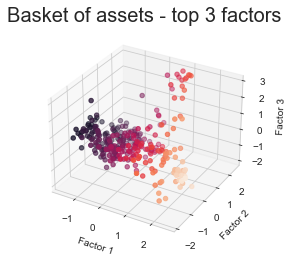

In [319]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(6,6))

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


x = df_beta[0]
y = df_beta[1]
z = df_beta[2]


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.set_title('Basket of assets - top 3 factors', fontsize=20)


plt.show()

## Run DBSCAN on dimension reduced returns data to get clusters

In [191]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn import preprocessing


X = preprocessing.StandardScaler().fit_transform(df_beta)
clf = DBSCAN(eps=2, min_samples=3)
print(clf)
print(X.shape)

clf.fit(df_beta)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)
clusters = clf.labels_

DBSCAN(eps=2, min_samples=3)
(300, 10)

Clusters discovered: 11


### Get a list of colors (# of colors = # of clusters)

In [321]:
def plot_colortable(colors, sort_colors=True, emptycols=0):
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)
    return names

In [324]:
import random
c=plot_colortable(mcolors.CSS4_COLORS)
color=random.choices(c, k=n_clusters_)

## Visualise clusters based on top three factors

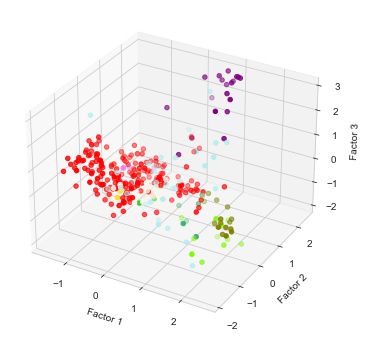

In [325]:
df_beta[labels==1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")

for i in range(-1,n_clusters_):
    ax.scatter(df_beta[labels==i][0], df_beta[labels==i][1],df_beta[labels==i][2], c=color[i],s=20)
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')

plt.show()

In [327]:
clustered_series = pd.Series(index=df_norm_ret.columns, data=clusters.flatten())

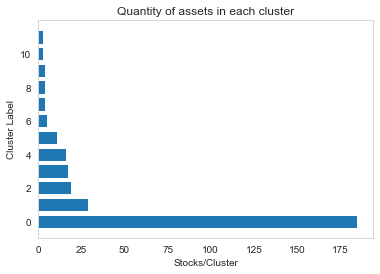

In [329]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Quantity of assets in each cluster')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster Label');

## Attach labels to PCA reduced returns DataFrame 

In [219]:
df_beta['labels']=labels
df_beta['labels'] = df_beta['labels'].astype("category")
df_beta=df_beta.set_index(df_norm_ret.T.index)
df_beta.sort_values(by=['labels'])

,0,1,2,3,4,5,6,7,8,9,labels
MMM,0.229450,-0.051210,-1.644110,0.417101,-1.509008,-0.571564,-0.353312,2.210308,-1.076661,0.157197,-1
CHRW,0.354411,-0.139934,1.097270,2.091160,-1.359976,-1.578217,-0.416585,-0.470709,-0.239222,1.086117,-1
CF,0.750163,1.476060,2.788644,1.200833,0.128634,0.754459,0.424586,-0.700471,1.815796,0.570405,-1
CLX,1.483486,-0.991737,-1.176628,3.124826,0.242733,-1.915412,-2.003043,-0.763804,-1.098480,-0.700945,-1
STZ,0.737702,-0.178321,0.048500,0.724547,0.268378,0.248713,0.710103,-1.261435,-0.569358,0.008740,-1
...,...,...,...,...,...,...,...,...,...,...,...
CMCSA,0.080479,0.026049,-0.859323,1.098791,1.957477,0.639998,0.964666,3.482917,2.161547,0.153745,9
LDOS,1.071002,0.221527,1.387176,0.176690,-0.063516,-0.588592,0.422479,0.015125,0.133004,3.294926,10
GD,1.231457,0.348709,0.785915,-0.657188,-0.983157,0.525075,1.981201,-0.469719,0.325991,2.351332,10
HII,1.366362,0.516622,1.077351,0.046548,-0.741976,-0.289577,1.276577,0.379740,1.092085,2.279878,10


## Lets look at the assets in a few of the clusters and see if they are from the same sector and what type of price relationship they have with each other

In [220]:
k_list=np.arange(0,n_clusters_,1)
k_list
d = {}
for k in k_list:
    d[k] = pd.DataFrame()
    d[k] = df_beta[df_beta['labels'] ==k]

In [225]:
d[1]

,0,1,2,3,4,5,6,7,8,9,labels
ADM,1.166733,1.409855,1.094829,-0.154869,-0.894281,0.829239,1.630701,0.501646,0.227661,0.161164,1
APA,0.303991,2.062884,2.797596,0.177983,-0.537406,-0.538416,-0.798855,-0.958397,0.225121,-0.657640,1
BKR,0.949640,1.948277,2.465324,0.286284,0.054649,-0.325116,-0.200877,0.265624,-0.662862,-0.842219,1
CVX,0.933771,2.206675,2.721205,0.078364,-0.913831,-0.571390,-0.515673,0.509894,-0.472632,-0.615343,1
COP,1.049616,2.319717,2.927746,0.044375,-0.899138,-0.266004,-0.710290,-0.540216,-0.283264,-0.099674,1
CTVA,0.346687,1.359103,0.798033,-0.478851,-0.895920,0.960361,0.397382,0.665601,-0.538108,0.909235,1
CTRA,1.107545,1.805608,2.386951,0.840245,-0.162095,-0.008115,-1.308610,0.359441,0.651237,-0.886896,1
DVN,0.588427,2.243799,2.845092,0.306059,-0.825041,-0.561739,-1.086488,-0.621186,0.591686,-1.261928,1
FANG,0.612171,2.346174,2.613704,0.269202,-0.766350,-0.424638,-1.304623,-0.614917,0.339490,-0.688965,1
EOG,1.011211,2.311518,2.931642,0.282145,-0.399784,-0.263339,-0.835958,-0.807304,0.105594,-0.496799,1


In [248]:
df=d[1]
ticker_list = list(df.index.values)
sector_list=[]
sector_dict={}
for i in ticker_list:
    stock = yf.Ticker(i)
    sector_dict[i]=stock.info['sector']
sector_dict

{'ADM': 'Consumer Defensive',
 'APA': 'Energy',
 'BKR': 'Energy',
 'CVX': 'Energy',
 'COP': 'Energy',
 'CTVA': 'Basic Materials',
 'CTRA': 'Energy',
 'DVN': 'Energy',
 'FANG': 'Energy',
 'EOG': 'Energy',
 'EQT': 'Energy',
 'XOM': 'Energy',
 'FMC': 'Basic Materials',
 'FCX': 'Basic Materials',
 'HAL': 'Energy',
 'HES': 'Energy',
 'KMI': 'Energy',
 'MRO': 'Energy',
 'MPC': 'Energy'}

In [330]:
df=d[2]
ticker_list = list(df.index.values)
sector_list=[]
sector_dict={}
for i in ticker_list:
    stock = yf.Ticker(i)
    sector_dict[i]=stock.info['sector']
sector_dict

{'AAP': 'Consumer Cyclical',
 'AZO': 'Consumer Cyclical',
 'HD': 'Consumer Cyclical',
 'LOW': 'Consumer Cyclical'}

In [331]:
df=d[3]
ticker_list = list(df.index.values)
sector_list=[]
sector_dict={}
for i in ticker_list:
    stock = yf.Ticker(i)
    sector_dict[i]=stock.info['sector']
sector_dict

{'ARE': 'Real Estate',
 'AMT': 'Real Estate',
 'AVB': 'Real Estate',
 'BXP': 'Real Estate',
 'CPT': 'Real Estate',
 'CCI': 'Real Estate',
 'DLR': 'Real Estate',
 'EQIX': 'Real Estate',
 'EQR': 'Real Estate',
 'ESS': 'Real Estate',
 'EXR': 'Real Estate',
 'FDS': 'Financial Services',
 'FRT': 'Real Estate',
 'PEAK': 'Real Estate',
 'INVH': 'Real Estate',
 'IRM': 'Real Estate',
 'KIM': 'Real Estate'}

In [332]:
df=d[4]
ticker_list = list(df.index.values)
sector_list=[]
sector_dict={}
for i in ticker_list:
    stock = yf.Ticker(i)
    sector_dict[i]=stock.info['sector']
sector_dict

{'LNT': 'Utilities',
 'AEE': 'Utilities',
 'AEP': 'Utilities',
 'ATO': 'Utilities',
 'CNP': 'Utilities',
 'CMS': 'Utilities',
 'ED': 'Utilities',
 'D': 'Utilities',
 'DTE': 'Utilities',
 'DUK': 'Utilities',
 'EIX': 'Utilities',
 'ETR': 'Utilities',
 'EVRG': 'Utilities',
 'ES': 'Utilities',
 'EXC': 'Utilities',
 'FE': 'Utilities'}

## As you can see, DBSCAN does a pretty decent job at clustering based on sector (I showed a few examples to limit computation, but feel free to look at the make up of all the different clusters by altering df=d[*cluster label*])

### Normalise returns for assets in any given cluster and plot to see relationship

In [263]:
def normalize_data(df):
    min = df.min()
    max = df.max()
    x = df 
    y = (x - min) / (max - min)
    return y

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

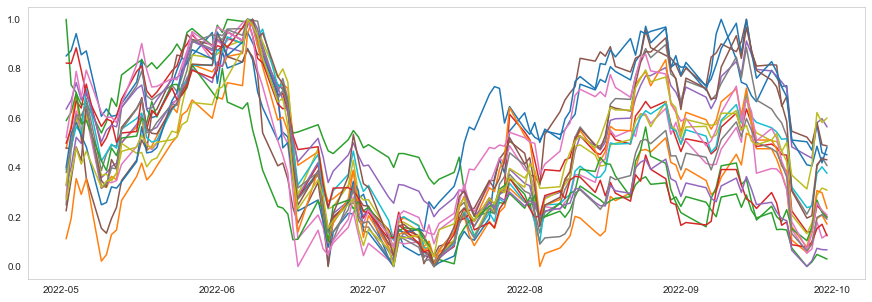

In [317]:
start_trade='2022-05-01'
end_trade='2022-10-01'
plt.figure(figsize=(15,5))

norm_df_price=pd.DataFrame(columns=ticker_list)
for j in ticker_list:
    X = yf.download(j, start = start_trade, end=end_trade)
    X['norm'] = normalize_data(X['Adj Close'])
    norm_df_price[i] = X['norm'].tolist()
    plt.plot(X.index.tolist(), X['norm'])

## As you can see, assets in cluster 1 are mainly energy stocks and are fairly correlated. Next step is to see which stocks are cointegrated and calculate Hurst exponents to find optimal pairs within each cluster.